In [1]:
import random
import numpy as np
from deap import base, creator, tools, algorithms
import networkx as nx
import matplotlib.pyplot as plt
import copy
import elitism
import json

In [2]:
with open('./real_data.json', 'r') as file:
    data = json.load(file)
data = data[0]
data

{'stations': {'Златоуст (1)': ['0', '38', '38', '25', '29', '7', '10'],
  'Кыштым (2)': ['26', '0', '7', '34', '20', '27', '35'],
  'Миасс (3)': ['15', '5', '0', '27', '16', '31', '24'],
  'Муслюмово (4)': ['12', '39', '1', '0', '2', '14', '20'],
  'Челябинск (5)': ['38', '38', '1', '28', '0', '33', '14'],
  'Полетаево (6)': ['21', '27', '24', '9', '1', '0', '3'],
  'Еманжелинск (7)': ['9', '3', '23', '25', '32', '37', '0']},
 'full_timetable': {'853': {'route': ['1', '3', '2'],
   'free_carriage': ['21', '21'],
   'timetable': ['02:00 - 02:38', '04:48 - 06:11', '13:35 - 13:58']},
  '801': {'route': ['1', '3', '2'],
   'free_carriage': ['34', '10'],
   'timetable': ['03:24 - 04:22', '06:32 - 07:06', '14:30 - 15:39']},
  '563': {'route': ['1', '3', '6', '5', '4'],
   'free_carriage': ['33', '20', '35', '3'],
   'timetable': ['03:43 - 04:26',
    '06:36 - 08:04',
    '11:42 - 11:59',
    '13:21 - 14:32',
    '16:42 - 17:34']},
  '182': {'route': ['1', '3', '6', '5', '7'],
   'free_carria

In [3]:
stations = [list(map(int, x)) for x in data['stations'].values()]
stations

[[0, 38, 38, 25, 29, 7, 10],
 [26, 0, 7, 34, 20, 27, 35],
 [15, 5, 0, 27, 16, 31, 24],
 [12, 39, 1, 0, 2, 14, 20],
 [38, 38, 1, 28, 0, 33, 14],
 [21, 27, 24, 9, 1, 0, 3],
 [9, 3, 23, 25, 32, 37, 0]]

In [4]:
trains = [x for x in data['full_timetable'].values()]
trains

[{'route': ['1', '3', '2'],
  'free_carriage': ['21', '21'],
  'timetable': ['02:00 - 02:38', '04:48 - 06:11', '13:35 - 13:58']},
 {'route': ['1', '3', '2'],
  'free_carriage': ['34', '10'],
  'timetable': ['03:24 - 04:22', '06:32 - 07:06', '14:30 - 15:39']},
 {'route': ['1', '3', '6', '5', '4'],
  'free_carriage': ['33', '20', '35', '3'],
  'timetable': ['03:43 - 04:26',
   '06:36 - 08:04',
   '11:42 - 11:59',
   '13:21 - 14:32',
   '16:42 - 17:34']},
 {'route': ['1', '3', '6', '5', '7'],
  'free_carriage': ['15', '18', '13', '36'],
  'timetable': ['02:44 - 03:14',
   '05:24 - 05:56',
   '09:34 - 11:00',
   '12:22 - 13:05',
   '15:43 - 16:34']},
 {'route': ['1', '3', '6', '5', '7'],
  'free_carriage': ['18', '1', '13', '21'],
  'timetable': ['03:23 - 03:48',
   '05:58 - 07:21',
   '10:59 - 11:20',
   '12:42 - 13:03',
   '15:41 - 16:15']},
 {'route': ['2', '3', '1'],
  'free_carriage': ['8', '33'],
  'timetable': ['01:00 - 02:01', '09:25 - 10:35', '12:45 - 13:00']},
 {'route': ['2', '3

In [5]:
for train in trains:
    train['free_carriage'].append(0)

In [6]:
timetable = ['02:44 - 03:14',
   '05:24 - 05:56',
   '09:34 - 11:00',
   '12:22 - 13:05',
   '23:43 - 00:34']

In [7]:
def convert_train_to_time_list(train_list):
    train_by_time = []
    for train_id in range(len(train_list)):
        time_list = train_list[train_id]['timetable']

        for i, time in enumerate(time_list):
            before_after = time.split('-')  # [05:24, 05:56]

            for j, rout_part in enumerate(before_after):
                free_carriage = int(train_list[train_id]['free_carriage'][i]) if j == 1 else None
                free_carriage = None if free_carriage == 0 else free_carriage
                hour, minut = [int(x) for x in rout_part.split(':')]
                new_t = hour * 100 + minut
                if i > 0 and train_by_time[-1]['time'] > new_t:
                    new_t *= 1000
                
                train_by_time.append({
                    'id': train_id, 
                    'time': new_t,
                    'st': int(train_list[train_id]['route'][i]), 
                    'free_carriage': free_carriage
                })
    return train_by_time

In [8]:
train_to_time = convert_train_to_time_list(trains)
train_to_time = sorted(train_to_time, key = lambda x: x['time'])
train_to_time

[{'id': 5, 'time': 100, 'st': 2, 'free_carriage': None},
 {'id': 8, 'time': 131, 'st': 2, 'free_carriage': None},
 {'id': 10, 'time': 142, 'st': 2, 'free_carriage': None},
 {'id': 7, 'time': 148, 'st': 2, 'free_carriage': None},
 {'id': 0, 'time': 200, 'st': 1, 'free_carriage': None},
 {'id': 6, 'time': 200, 'st': 2, 'free_carriage': None},
 {'id': 11, 'time': 200, 'st': 3, 'free_carriage': None},
 {'id': 14, 'time': 200, 'st': 4, 'free_carriage': None},
 {'id': 5, 'time': 201, 'st': 2, 'free_carriage': 8},
 {'id': 7, 'time': 210, 'st': 2, 'free_carriage': 22},
 {'id': 14, 'time': 221, 'st': 4, 'free_carriage': 18},
 {'id': 6, 'time': 233, 'st': 2, 'free_carriage': 12},
 {'id': 0, 'time': 238, 'st': 1, 'free_carriage': 21},
 {'id': 3, 'time': 244, 'st': 1, 'free_carriage': None},
 {'id': 9, 'time': 251, 'st': 2, 'free_carriage': None},
 {'id': 8, 'time': 301, 'st': 2, 'free_carriage': 26},
 {'id': 11, 'time': 301, 'st': 3, 'free_carriage': 23},
 {'id': 10, 'time': 303, 'st': 2, 'free_c

In [9]:
train_onboard_main = [[0] * len(stations) for _ in range(len(data['full_timetable']))]
train_onboard_main

[[0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0]]

In [10]:
HROM_LENGHT = sum([1 for x in train_to_time if x['free_carriage'] is not None])

# константы генетического алгоритма
POPULATION_SIZE = 700   # количество индивидуумов в популяции
P_CROSSOVER = 0.9       # вероятность скрещивания
P_MUTATION = 0.2        # вероятность мутации индивидуума
MAX_GENERATIONS = 200    # максимальное количество поколений
HALL_OF_FAME_SIZE = 10
INDIVID_SIZE = 4

MAX_INDIVID = max([int(y) for x in [i['free_carriage'] for i in trains] for y in x])
MAX_INDIVID

37

In [11]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

In [12]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

In [25]:
def create_individ(max_size, count):
    res = []
    for _ in range(count):
        tmp = [random.randint(0, MAX_INDIVID) for _ in range(max_size)]
        i = 0
        while sum(tmp) > (MAX_INDIVID//2 * max_size) and i != len(tmp):
            tmp[i] = 0
            i += 1
        random.shuffle(tmp)
        res += tmp
    return creator.Individual(res)

In [26]:
create_individ(HROM_LENGHT ,INDIVID_SIZE)

[9,
 29,
 29,
 20,
 0,
 20,
 3,
 0,
 15,
 6,
 31,
 24,
 19,
 30,
 22,
 25,
 26,
 15,
 13,
 3,
 37,
 18,
 32,
 31,
 32,
 27,
 10,
 1,
 36,
 6,
 3,
 15,
 31,
 18,
 10,
 28,
 34,
 0,
 0,
 5,
 31,
 12,
 18,
 0,
 30,
 0,
 0,
 0,
 9,
 19,
 12,
 36,
 23,
 37,
 37,
 21,
 0,
 10,
 0,
 37,
 24,
 32,
 1,
 1,
 33,
 36,
 0,
 14,
 34,
 30,
 19,
 26,
 32,
 1,
 15,
 37,
 0,
 3,
 30,
 2,
 31,
 7,
 21,
 16,
 7,
 36,
 16,
 17,
 14,
 24,
 26,
 12,
 17,
 30,
 14,
 15,
 2,
 22,
 35,
 25,
 36,
 18,
 6,
 21,
 0,
 8,
 9,
 6,
 28,
 6,
 17,
 15,
 10,
 5,
 3,
 8,
 3,
 18,
 22,
 34,
 7,
 30,
 34,
 13,
 18,
 0,
 33,
 35,
 37,
 23,
 36,
 37,
 25,
 18,
 7,
 5,
 0,
 21,
 32,
 29,
 16,
 16,
 3,
 11,
 20,
 19,
 19,
 8,
 0,
 15,
 19,
 11,
 12,
 16,
 17,
 15,
 28,
 11,
 30,
 24,
 21,
 7,
 36,
 27,
 0,
 25,
 10,
 6,
 25,
 15,
 20,
 32]

In [27]:
toolbox = base.Toolbox()
# toolbox.register("randomOper", create_individ, INDIVID_SIZE)
toolbox.register("individualCreator", create_individ, HROM_LENGHT, INDIVID_SIZE)
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)

In [28]:
population = toolbox.populationCreator(n=POPULATION_SIZE)
population[0]

[5,
 0,
 3,
 1,
 3,
 19,
 8,
 16,
 29,
 29,
 4,
 0,
 4,
 28,
 32,
 26,
 28,
 23,
 34,
 13,
 24,
 3,
 30,
 35,
 25,
 2,
 37,
 18,
 26,
 2,
 27,
 0,
 29,
 24,
 26,
 22,
 24,
 36,
 8,
 4,
 32,
 11,
 5,
 24,
 0,
 17,
 0,
 0,
 11,
 15,
 34,
 3,
 9,
 11,
 9,
 20,
 26,
 26,
 19,
 19,
 36,
 26,
 0,
 27,
 19,
 35,
 14,
 24,
 0,
 14,
 18,
 0,
 22,
 3,
 3,
 8,
 33,
 37,
 20,
 0,
 35,
 32,
 33,
 36,
 20,
 31,
 24,
 26,
 29,
 16,
 0,
 35,
 2,
 22,
 36,
 1,
 18,
 0,
 6,
 14,
 34,
 21,
 0,
 0,
 19,
 0,
 37,
 0,
 20,
 12,
 0,
 30,
 14,
 0,
 36,
 31,
 23,
 18,
 37,
 13,
 29,
 9,
 9,
 24,
 32,
 20,
 26,
 16,
 23,
 5,
 12,
 33,
 14,
 6,
 24,
 36,
 32,
 26,
 15,
 2,
 1,
 22,
 34,
 35,
 30,
 3,
 24,
 17,
 29,
 33,
 25,
 5,
 5,
 0,
 17,
 6,
 9,
 16,
 25,
 25,
 27,
 11,
 0,
 19,
 1,
 33,
 23,
 15,
 0,
 18,
 0,
 35]

In [36]:
PENALTY_COST = 200

def shedule_cost(individual):
    tmp_stations = copy.deepcopy(stations)
    train_to_time_new = copy.deepcopy(train_to_time)
    train_onboard = copy.deepcopy(train_onboard_main)
    current_cost = 0
    hrom_index = 0
    penalty_count = 0
    # print(individual)

    for time, train in enumerate(train_to_time_new):
        train_station = train['st'] - 1
        vagon_to_move = 0
        for vagon_id in range(len(tmp_stations)):
            if train['free_carriage'] is None:  # это мы приехали на станцию
                if vagon_id != train_station:  # если вагоны приехали не сюда, то считаем
                    tmp_stations[train_station][vagon_id] += train_onboard[train['id']][vagon_id]
                train_onboard[train['id']][vagon_id] = 0
            else:
                tmp_stations[train_station][vagon_id] -= individual[hrom_index]
                train_onboard[train['id']][vagon_id] = individual[hrom_index]

                if tmp_stations[train_station][vagon_id] < 0: # если меньше нуля, то корректируем текущее состояние 
                    train_onboard[train['id']][vagon_id] = 0 - tmp_stations[train_station][vagon_id]
                    tmp_stations[train_station][vagon_id] = 0
                    penalty_count += 1
                
                vagon_to_move += individual[hrom_index]
                hrom_index += 1

            if hrom_index >= len(individual):
                hrom_index = len(individual) - 1

        if train['free_carriage'] is not None:
            # hrom_index += 1
            if hrom_index >= len(individual):
                hrom_index = len(individual) - 1
            if vagon_to_move > train['free_carriage']:
                penalty_count += 1

        row_sums = []
        for row in tmp_stations:
            row_sum = float(sum(row[-len(tmp_stations):])) / float(len(tmp_stations))
            row_sums.append(row_sum)

        
        # print(row_sums)

        current_cost += sum(row_sums)
    
    # for state in tmp_stations:
        # print(state)
        # current_cost += sum(state)

    current_cost += penalty_count * PENALTY_COST
    return current_cost,

In [37]:
shedule_cost(population[0])

(54978.28571428572,)

In [38]:
def mate(ind1, ind2):
    ind1, ind2 = tools.cxTwoPoint(ind1, ind2)
    return ind1, ind2

In [39]:
def mut(individual, indpb):           
    individual = tools.mutShuffleIndexes(individual, indpb)
    return individual,

In [40]:
toolbox.register("evaluate", shedule_cost)
toolbox.register("select", tools.selTournament, tournsize=2)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=1.0/HROM_LENGHT)

In [41]:
hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

In [42]:
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("min", np.min)
stats.register("avg", np.mean)

In [43]:
population, logbook = elitism.eaSimpleWithElitism(population, toolbox,
                                        cxpb=P_CROSSOVER,
                                        mutpb=P_MUTATION,
                                        ngen=MAX_GENERATIONS,
                                        halloffame=hof,
                                        stats=stats,
                                        verbose=True)

gen	nevals	min    	avg  
0  	700   	41022.3	51515
1  	624   	40878.1	49801.4
2  	631   	40352.6	48006.7
3  	635   	39546.7	46422.3
4  	627   	39179.6	44624.2
5  	640   	38923.3	43198.2
6  	637   	38643  	42222.6
7  	638   	38643  	41654.5
8  	638   	37788.9	41099.5
9  	639   	37136.6	40540.5
10 	630   	36646.4	40067.9
11 	620   	36008.9	39539.6
12 	635   	34929.3	39082.1
13 	643   	34859  	38605.1
14 	628   	33428.4	38059.7
15 	638   	33420.3	37536.5
16 	626   	33420.3	37046.4
17 	632   	33417.9	36460.5
18 	642   	32555.1	35999  
19 	627   	32535.6	35546.7
20 	634   	32076.6	34982  
21 	633   	31035.6	34463.2
22 	644   	30272.1	34130.5
23 	642   	30272.1	33732.5
24 	632   	30272.1	33393.8
25 	640   	29290.4	33114.8
26 	633   	29290.4	32752.5
27 	644   	29290.4	32324.4
28 	642   	29290.4	31934  
29 	640   	28634.9	31594.1
30 	640   	28481  	31329.3
31 	634   	28127  	30854  
32 	649   	26886.1	30432.4
33 	642   	26886.1	30000.7
34 	628   	26828.6	29610.9
35 	624   	26524.6	29265.2
36 	6

In [55]:
maxFitnessValues, meanFitnessValues = logbook.select("min", "avg")

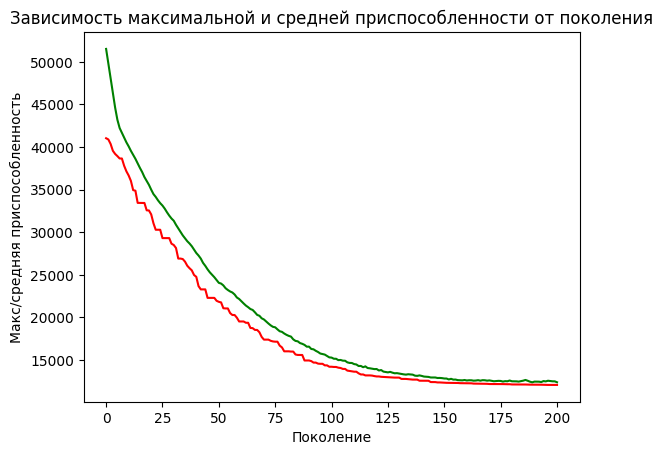

In [56]:
plt.plot(maxFitnessValues, color='red')
plt.plot(meanFitnessValues, color='green')
plt.xlabel('Поколение')
plt.ylabel('Макс/средняя приспособленность')
plt.title('Зависимость максимальной и средней приспособленности от поколения')

plt.show()

In [57]:
best_shedule = hof.items[0]
best_shedule

[0,
 0,
 6,
 7,
 0,
 10,
 9,
 18,
 0,
 0,
 0,
 0,
 0,
 3,
 8,
 35,
 0,
 0,
 0,
 14,
 18,
 6,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 7,
 4,
 2,
 3,
 5,
 0,
 0,
 0,
 0,
 6,
 7,
 0,
 11,
 0,
 4,
 0,
 8,
 4,
 3,
 4,
 0,
 0,
 1,
 3,
 0,
 0,
 8,
 25,
 28,
 7,
 0,
 6,
 0,
 5,
 0,
 0,
 0,
 0,
 7,
 0,
 0,
 0,
 1,
 15,
 0,
 18,
 0,
 4,
 6,
 0,
 0,
 1,
 0,
 1,
 4,
 0,
 0,
 8,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 16,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 1,
 0,
 0,
 0,
 0,
 3,
 4,
 1,
 35,
 0,
 3,
 8,
 0,
 3,
 11,
 2,
 0,
 1,
 28,
 2,
 10,
 7,
 0,
 0,
 7,
 0,
 12,
 0,
 8,
 0,
 0,
 1,
 0,
 0,
 0,
 2,
 0,
 0,
 29,
 2,
 24,
 10,
 27,
 0,
 0,
 0,
 0,
 0,
 0,
 8,
 0,
 0,
 26,
 9,
 33,
 26,
 21,
 26,
 18,
 9,
 0,
 0,
 4,
 0,
 0,
 0,
 0]

In [904]:
for i in range(1, len(best_shedule), 2):
    print(best_shedule[i])

10
0
0
10
0
17


In [58]:
shedule_cost(best_shedule)

(12043.14285714286,)

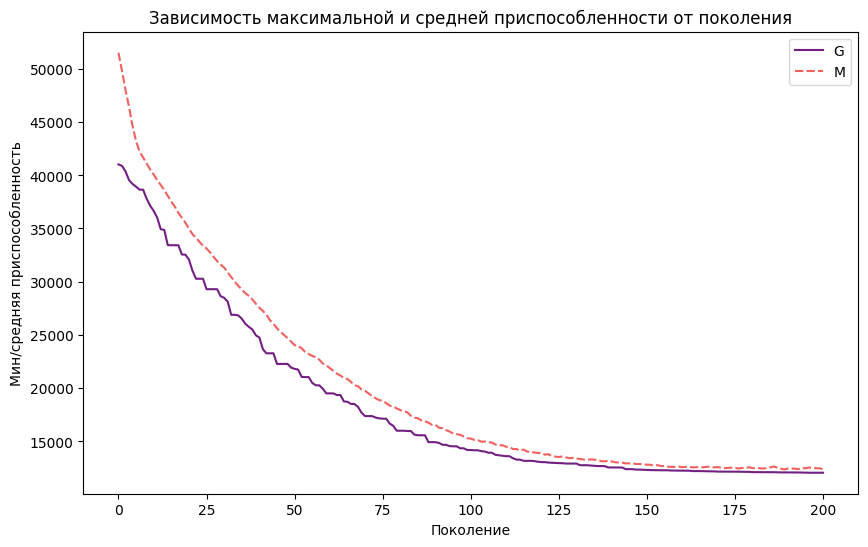

In [74]:
import seaborn as sns
import pandas as pd

# dt = np.ndarray(logbook.select("min", "avg"))
a = pd.DataFrame({
    'G': maxFitnessValues,
    'M': meanFitnessValues
})

line,ax = plt.subplots(figsize=(10,6))

ax = sns.lineplot(data=a, legend='auto', palette="magma")
ax.set_xlabel('Поколение')
ax.set_ylabel('Мин/средняя приспособленность')
ax.set_title('Зависимость максимальной и средней приспособленности от поколения')

line.savefig("genetic.png");
